In [2]:
import cv2
import os
import numpy as np
import PIL
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pathlib
from collections import defaultdict
import glob
import seaborn as sns
import zipfile
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report , confusion_matrix

In [3]:
input_root = os.path.join(os.getcwd() , "dataset" )
datadir = pathlib.Path(input_root)
datadir

WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset')

In [4]:
list(datadir.glob('*/*.jpg'))

[WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/00ae0969-e9f4-45f4-bfd1-0a0e9bce41d8.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/0149d275-f23d-477c-a5be-4b10f13d1fad.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/01ac46ca-db39-44c6-99b7-ab3c0d90dd20.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/059dcd74-da75-4c2c-93e9-78b60c1333c6.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/074a90b7-3152-414c-80d8-52764ee8fef8.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/0751b08f-c164-447b-a22c-7298c959efaa.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProject/MLProj/dataset/cardboard/07692a5e-eb76-48d6-9848-bb9c3be69f5e.jpg'),
 WindowsPath('c:/Users/Administrator/Desktop/Projectrs/MLProje

In [5]:
class_images_dict = {
    'cardboard' : list(datadir.glob("cardboard/*")),
    'glass' : list(datadir.glob("glass/*")),
    'metal' : list(datadir.glob("metal/*")),
    'paper' : list(datadir.glob("paper/*")),
    'plastic' : list(datadir.glob("plastic/*")),
    'trash' : list(datadir.glob("trash/*")),
}

class_label_dic = {
    'cardboard' : 1,
    'glass' : 2,
    'metal' : 3,
    'paper' : 4,
    'plastic' : 5,
    'trash' : 6,
}
    

In [6]:
# Filter corrupted images
for class_name, image_paths in class_images_dict.items():
    valid_images = []
    for path in image_paths:
        try:
            # Try opening the image
            img = PIL.Image.open(str(path))
            img.verify()  # verify checks for corruption without loading the full image
            valid_images.append(path)
        except (IOError, SyntaxError):
            # If opening fails, skip the image
            print(f"Corrupted image skipped: {path}")
    class_images_dict[class_name] = valid_images

Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\2ec9d19b-8027-4c77-a13f-5eee033b9868.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\31381a44-38d6-4a44-9384-7690727801bc.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\345bdb67-4190-4235-a16f-b60c1556a28d.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\38b3e4da-738c-4694-a946-55101b25ad53.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\4840d678-7af4-4a2d-bda1-338c2f2a59c5.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\509251d8-4e3a-4f1e-aabc-4d034b0f2455.jpg
Corrupted image skipped: c:\Users\Administrator\Desktop\Projectrs\MLProject\MLProj\dataset\cardboard\5b7da318-c2ab-4c29-8ace-19895a890840.jpg
Corrup

Loaded cardboard


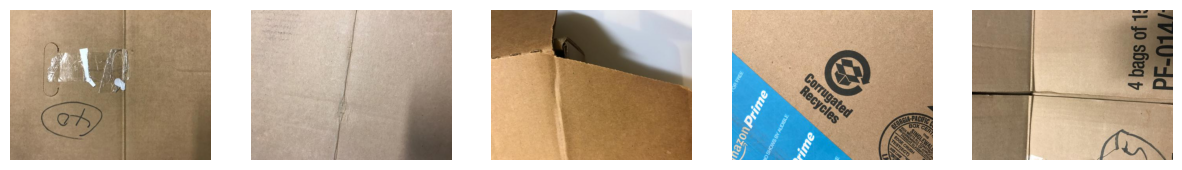

Loaded glass


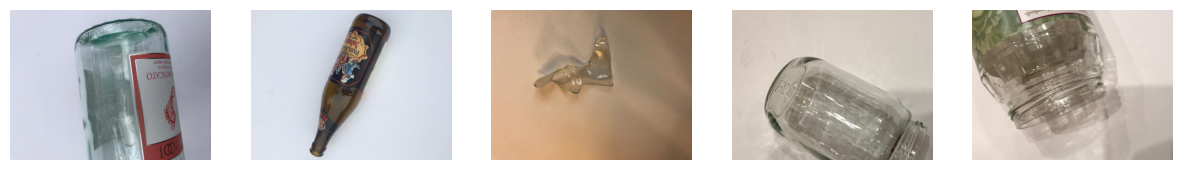

Loaded metal


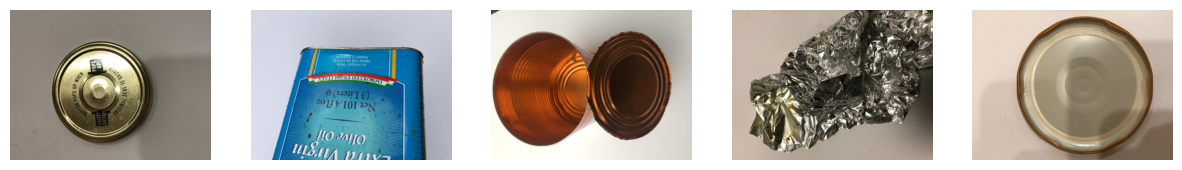

Loaded paper


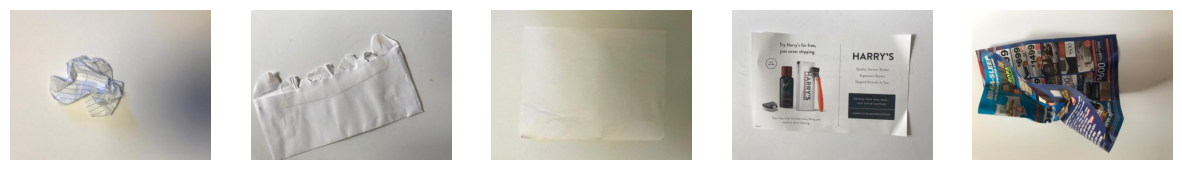

Loaded plastic


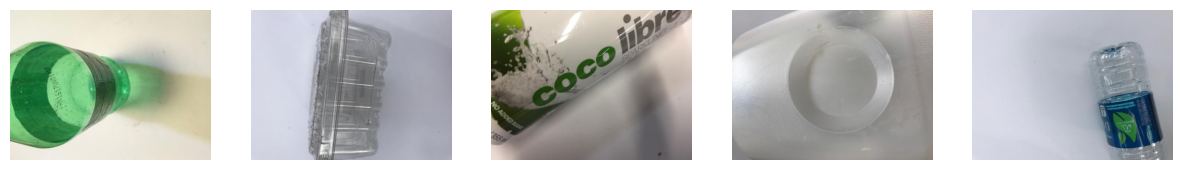

Loaded trash


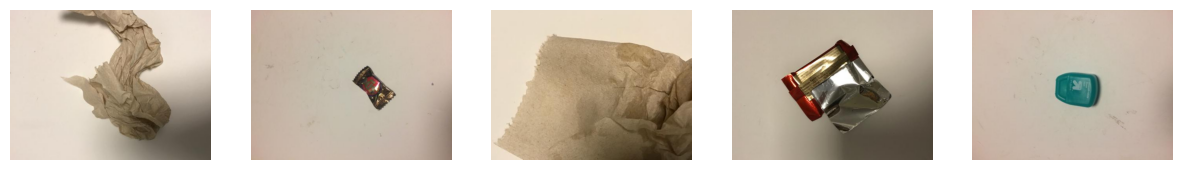

In [7]:
for class_name, image_list in class_images_dict.items():
    images = [PIL.Image.open(p) for p in image_list[:5]]
    
    print(f"Loaded {class_name}")
    
    # Create a figure with 1 row and 5 columns
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

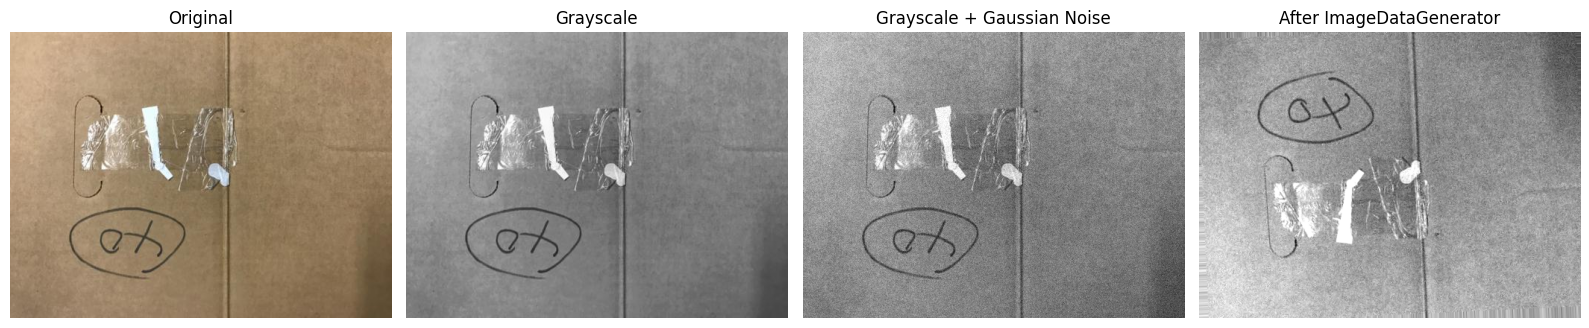

In [33]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,       # rotate images
    horizontal_flip=True,    # flip horizontally
    vertical_flip=True,      # flip vertically
    brightness_range=[0.7,1.3]  # random brightness
)
def add_gaussian_noise(image, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, image.shape)
    noisy_img = image / 255.0 + noise
    noisy_img = np.clip(noisy_img, 0.0, 1.0)  # keep values in [0,1]
    return (noisy_img * 255).astype(np.uint8)

# ---------- Load image ----------
img = cv2.imread(class_images_dict['cardboard'][0])  # <-- change path
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ---------- Convert to grayscale ----------
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------- Add Gaussian noise ----------
gray_noisy = add_gaussian_noise(gray)

# ---------- Prepare for ImageDataGenerator ----------
gray_noisy = np.expand_dims(gray_noisy, axis=-1)  # (H, W, 1)
img_exp = np.expand_dims(gray_noisy, axis=0)      # (1, H, W, 1)

# ---------- Generate ONE augmented image ----------
augmented = next(datagen.flow(img_exp, batch_size=1))[0]
augmented = augmented.squeeze()  # (H, W)

# ---------- Display ----------
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Grayscale")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Grayscale + Gaussian Noise")
plt.imshow(gray_noisy.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("After ImageDataGenerator")
plt.imshow(augmented, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

All of my images are 384 X 512 px and the 3 dimensions here represent the color value for the RGB Channel red blue green

In [34]:
class_features_dic = {}

for class_name, image_paths in class_images_dict.items():
    features_list = []

    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = add_gaussian_noise(img)

        img = np.expand_dims(img, axis=-1)  # (H, W, 1)

        # ✅ 1) ADD ORIGINAL IMAGE
        original_features = img.flatten() / 255.0
        features_list.append(original_features)

        # Prepare for augmentation
        img_exp = np.expand_dims(img, 0)  # (1, H, W, 1)

        # ✅ 2) ADD AUGMENTED IMAGES
        aug_per_image = 5
        for i, batch in enumerate(datagen.flow(img_exp, batch_size=1)):
            augmented_img = batch[0]

            features = augmented_img.flatten() / 255.0
            features_list.append(features)

            if i + 1 >= aug_per_image:
                break

    class_features_dic[class_name] = np.array(features_list)
    print(f"{class_name}: {len(features_list)} samples")


cardboard: 1482 samples
glass: 2310 samples
metal: 1890 samples
paper: 2694 samples
plastic: 2178 samples
trash: 636 samples


In [35]:
X , y = [] , []
for class_name , features_list in class_features_dic.items() :
    for features in features_list : 
        X.append(features)
        y.append(class_label_dic[class_name])

In [36]:
X_train , X_test , y_train , y_test = train_test_split(X , y , random_state=0)

Accuracy: 0.3435

Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.46      0.30       352
           2       0.34      0.34      0.34       561
           3       0.51      0.19      0.28       477
           4       0.50      0.33      0.40       702
           5       0.33      0.45      0.38       549
           6       0.32      0.24      0.27       157

    accuracy                           0.34      2798
   macro avg       0.37      0.34      0.33      2798
weighted avg       0.39      0.34      0.34      2798



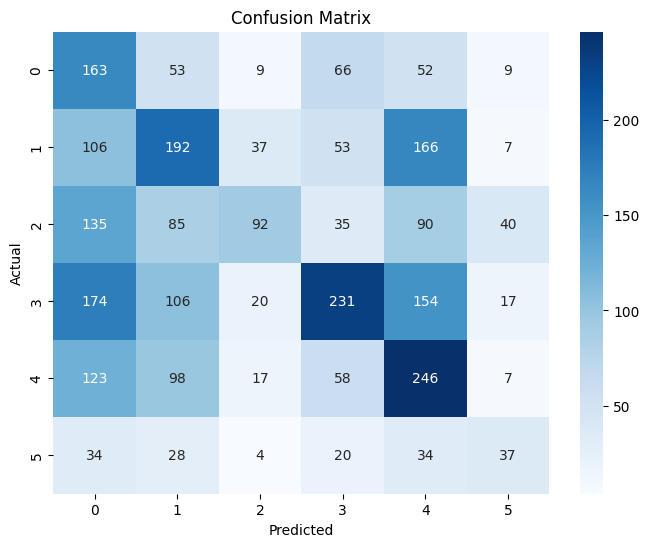

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')  # you can change n_neighbors
knn.fit(X_train, y_train)

# 3️⃣ Predict on test set
y_pred = knn.predict(X_test)

# 4️⃣ Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# 5️⃣ Optional: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()